In [1]:
import numpy as np
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt

import vis_sim
from croissant.healpix import grid2healpix

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
theta, phi = hp.pix2ang(NSIDE, np.arange(NPIX), nest=False, lonlat=False)
I = np.ones(NPIX)
Q = -np.cos(2*phi) # + pi?
U = np.sin(2*phi) # +pi?
RM = 10

In [3]:
# generate frequency arrays
fmin = 30e6  # min freq, 30 MHz
bw = 25e3 * 64  # bandwidth
nchan = 64 * 64 # * 10
freq = np.linspace(0, bw, num=nchan) + fmin

### Beam

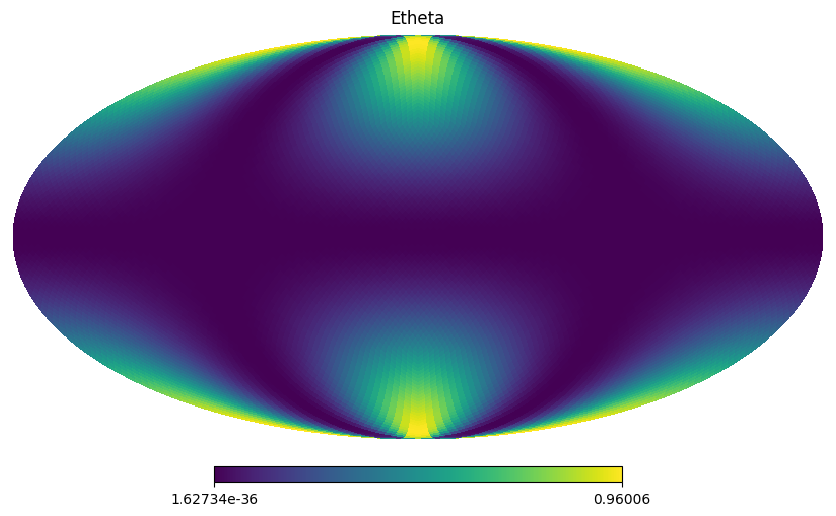

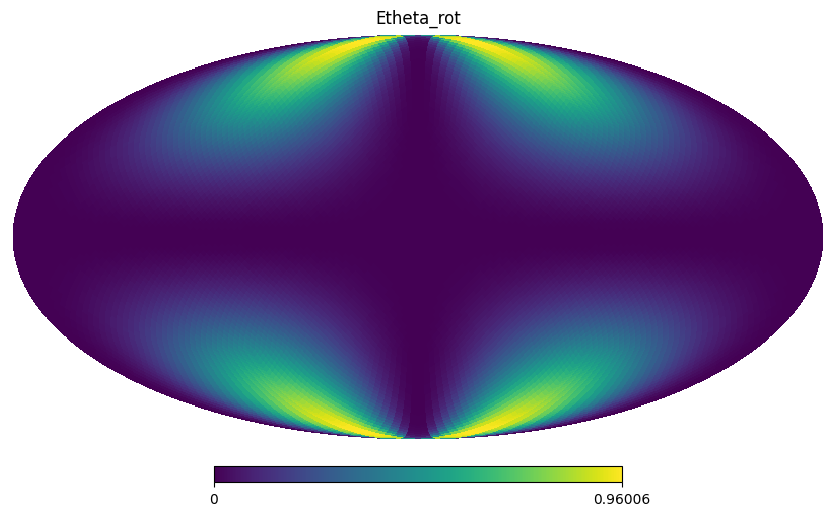

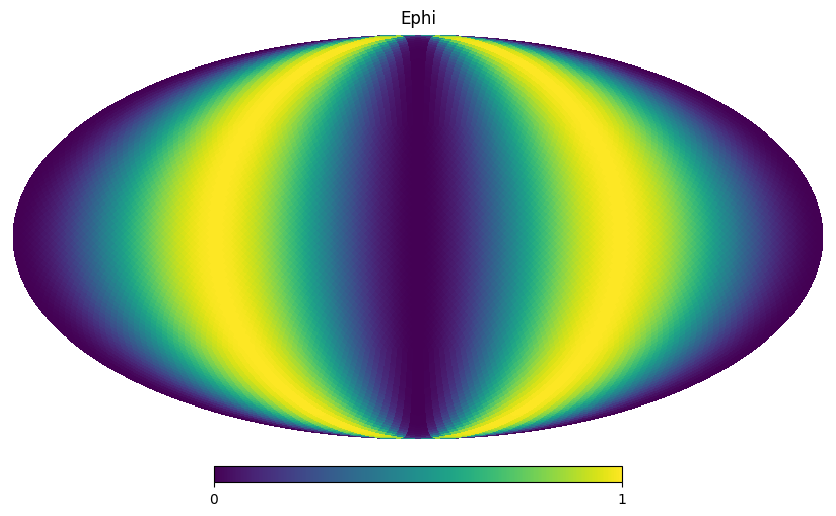

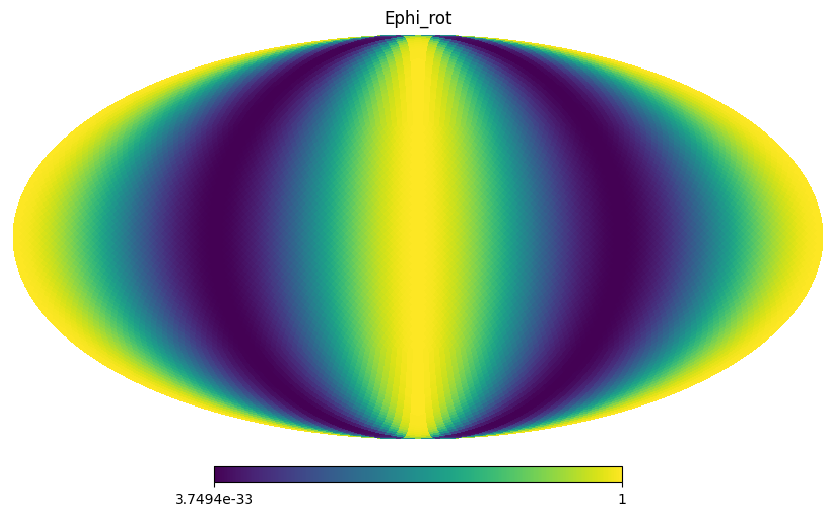

In [4]:
# short dipole
E_theta = -np.cos(theta) * np.cos(phi)
E_phi = np.sin(phi)
beam_X = np.array([E_theta, E_phi])

# for the dipole along Y, we get cos(phi)->sin(phi) and sin(phi)->-cos(phi)
yE_theta = -np.cos(theta) * np.sin(phi)
yE_phi = -np.cos(phi)
beam_Y = np.array([yE_theta, yE_phi])

hp.mollview(beam_X[0]**2, title="Etheta")
hp.mollview(beam_Y[0]**2, title="Etheta_rot")
hp.mollview(beam_X[1]**2, title="Ephi")
hp.mollview(beam_Y[1]**2, title="Ephi_rot")

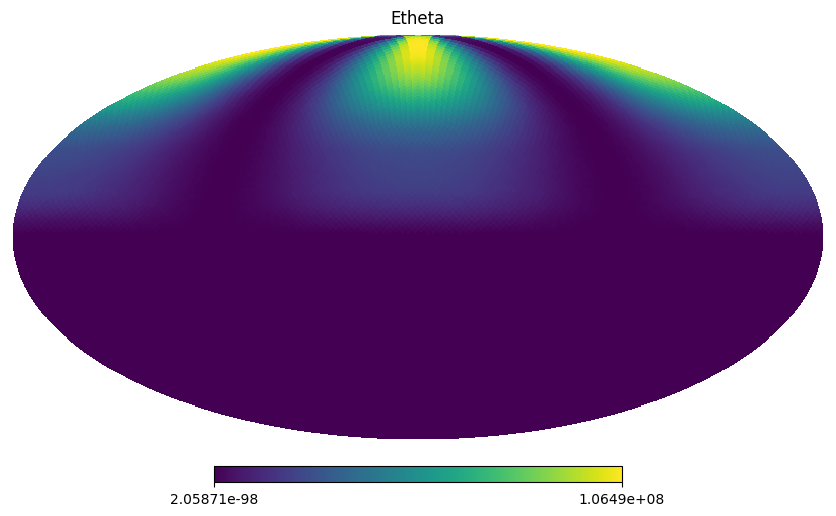

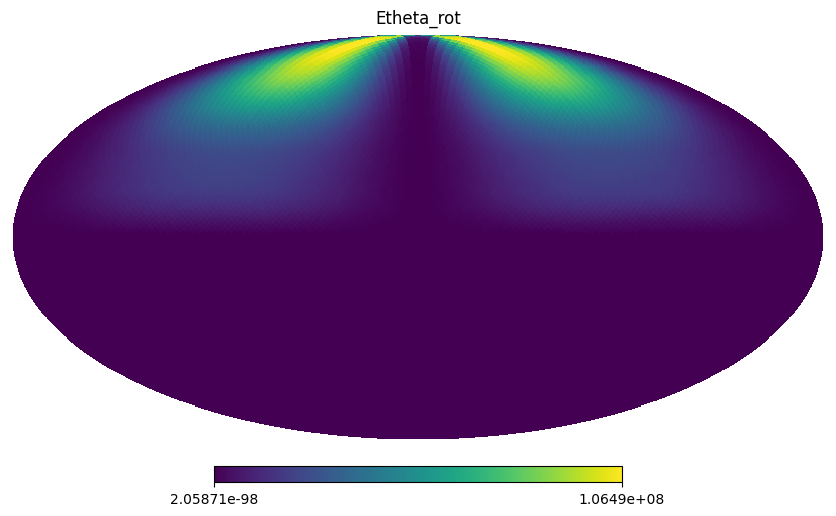

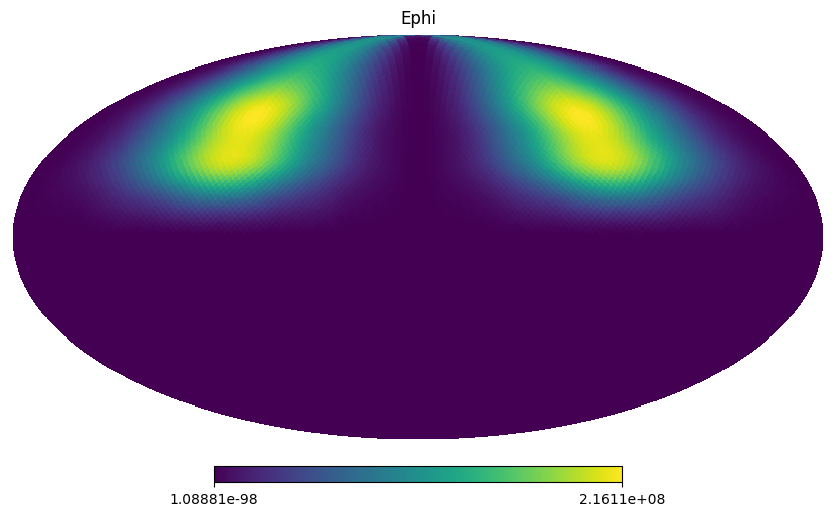

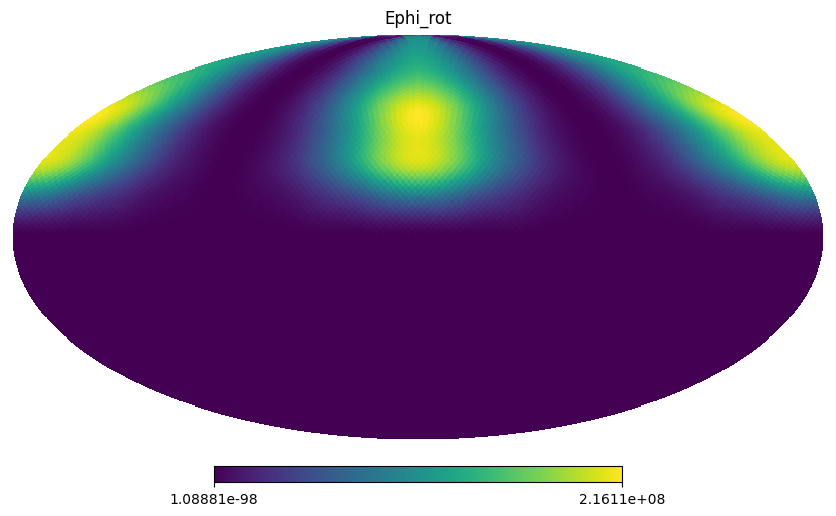

In [5]:
# lusee beam
def read_beam(fname):
    with fits.open(fname) as hdul:
        E_theta = hdul["Etheta_real"].data + 1j * hdul["Etheta_imag"].data
        E_phi = hdul["Ephi_real"].data + 1j * hdul["Ephi_imag"].data
        ix = np.argwhere(hdul["freq"].data == 30)[0, 0]
        E_theta = E_theta[ix]
        E_phi = E_phi[ix]

    lusee_Y = np.array([E_theta.real, E_theta.imag, E_phi.real, E_phi.imag])[:, :, :-1]
    lusee_Y = np.concatenate((lusee_Y, np.zeros_like(lusee_Y)[:, :-1, :]), axis=1)
    #lusee_Y /= np.abs(lusee_Y).max(axis=(1,2))[:, None, None]
    return lusee_Y
    
lusee_Y = read_beam("data/hfss_lbl_3m_75deg.2port.fits")  # along Y axis
#beam = read_beam("data/feko_bnl_3m_75deg.2port.fits")
lusee_X = np.roll(lusee_Y, -90, axis=-1)
lusee_X = grid2healpix(lusee_X, NSIDE)
lusee_Y = grid2healpix(lusee_Y, NSIDE)

beam_X = np.array([lusee_X[0] + 1j * lusee_X[1], lusee_X[2] + 1j * lusee_X[3]])
beam_Y = np.array([lusee_Y[0] + 1j * lusee_Y[1], lusee_Y[2] + 1j * lusee_Y[3]])

hp.mollview(np.abs(beam_X[0])**2, title="Etheta")
hp.mollview(np.abs(beam_Y[0])**2, title="Etheta_rot")
hp.mollview(np.abs(beam_X[1])**2, title="Ephi")
hp.mollview(np.abs(beam_Y[1])**2, title="Ephi_rot")

In [6]:
# cut source and beam where the source is nonzero
T_MAX_DEG = 5
npix_src = hp.ang2pix(NSIDE, 359, 90-T_MAX_DEG, lonlat=True) + 1  # number of pixels in source
stokes = np.array([I, Q, U])[:, :npix_src]
beam1 = beam_X[:, :npix_src]
beam2 = beam_Y[:, :npix_src]
beam = np.array([beam1, beam2])

In [7]:
def narrow(vis, f):
    return vis[:, :64], f[:64]

def med(vis, f, res=64):
    return vis.reshape(vis.shape[0], -1, res).mean(axis=-1)[:, :64], f.reshape(-1, res).mean(axis=-1)[:64]

def fat(vis, f):
    return vis.reshape(vis.shape[0], -1, 64*64).mean(axis=-1), f.reshape(-1, 64*64).mean(axis=-1)

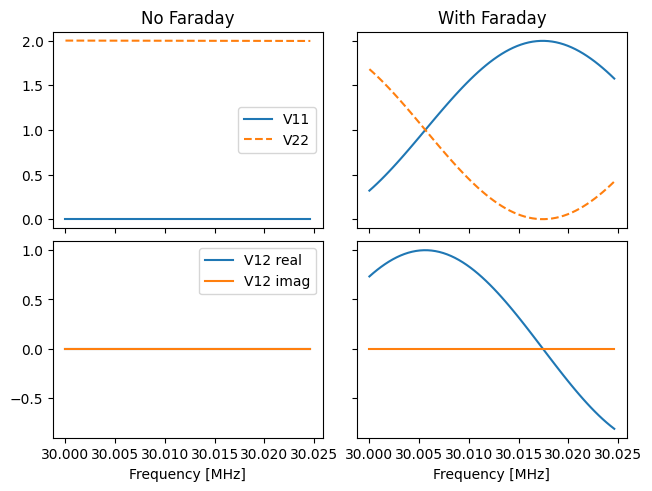

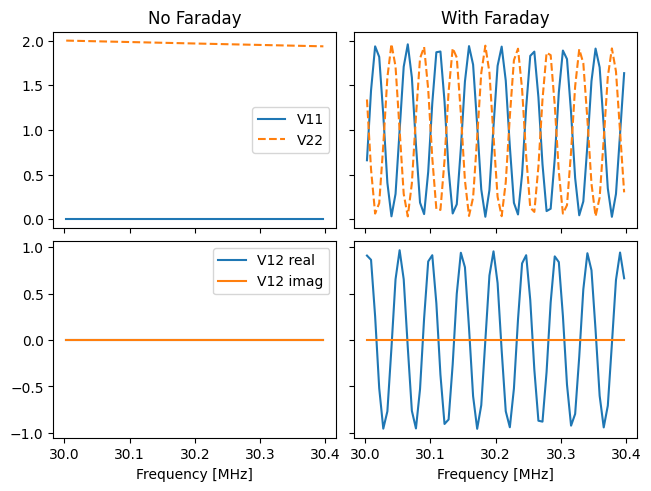

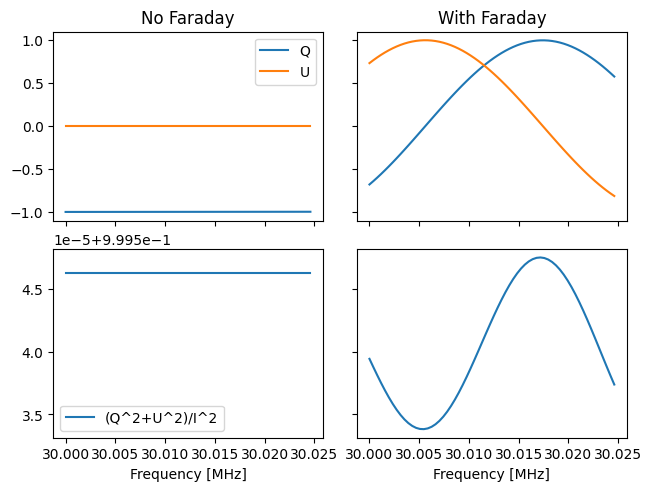

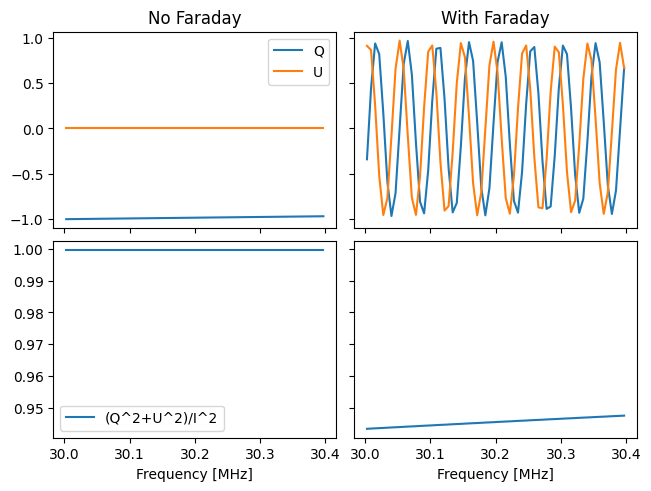

In [8]:
sim = vis_sim.Simulator(freq, stokes, RM, beam, healpix=True, nside=NSIDE)
vis = sim.vis(faraday=False, use_spec=False)
vis_rot = sim.vis(faraday=True, use_spec=False)

vis_narrow, f_narrow = narrow(vis, freq)
vis_med, f_med = med(vis, freq, res=16)

vis_rot_narrow = narrow(vis_rot, freq)[0]
vis_rot_med = med(vis_rot, freq, res=16)[0]

vis_sim.plot_vis(f_narrow/1e6, vis_narrow, vis_rot_narrow)
vis_sim.plot_vis(f_med/1e6, vis_med, vis_rot_med)

vis_sim.plot_stokes(f_narrow/1e6, vis_sim.vis2stokes(vis_narrow), vis_sim.vis2stokes(vis_rot_narrow))
vis_sim.plot_stokes(f_med/1e6, vis_sim.vis2stokes(vis_med), vis_sim.vis2stokes(vis_rot_med))

In [9]:
print(f_narrow.shape, np.mean(np.diff(f_narrow)))
print(f_med.shape, np.mean(np.diff(f_med)))

(64,) 390.7203907203816
(64,) 6251.526251526224


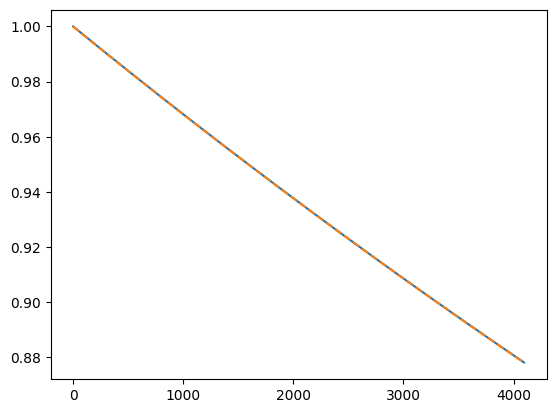

In [10]:
# stokes I
plt.plot(vis_sim.vis2stokes(vis)[0])
plt.plot(vis_sim.vis2stokes(vis_rot)[0], ls="--")